Computer vision Part-1

Colab Written by Mansi Vekariya

A Colab that contrasts the performance of supervised contrastive loss with traditional softmax-based classification using the CIFAR-10 dataset.

Step 1: Setup and Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model


Step 2: Load and Preprocess the Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0


170498071/170498071 [==============================] - 2s 0us/step


Step 3: Define the Base Model

In [3]:
def create_base_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
    ])
    return model

base_model = create_base_model()


Step 4: Supervised Contrastive Loss

In [12]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, embeddings):
        # Normalize embeddings to unit length
        embeddings = tf.math.l2_normalize(embeddings, axis=1)

        # Compute pairwise cosine similarities
        dot_product = tf.matmul(embeddings, embeddings, transpose_b=True)

        # Get the number of classes from the labels shape
        num_classes = tf.shape(labels)[-1]

        # Convert labels to one-hot if they are not already
        labels = tf.cast(labels, dtype=tf.int32)  # Ensure labels are integers
        if len(labels.shape) == 1:
            labels = tf.one_hot(labels, depth=num_classes)

        # Create mask for positive samples (set diagonal to zero)
        mask = 1 - tf.eye(num_classes, dtype=tf.float32)
        mask = tf.tile(mask[None, :, :], [tf.shape(labels)[0], 1, 1])  # Tile mask for each item in batch

        # Exponentiate the negative distances scaled by the temperature
        exp_logits = tf.exp(dot_product / self.temperature)

        # Apply mask to exclude self-comparisons
        exp_logits *= mask

        # Sum of exp(logits) for all negative pairs
        sum_exp_logits = tf.reduce_sum(exp_logits, axis=2)

        # Loss calculation: -log(positive / sum of negatives)
        positive_logits = tf.linalg.diag_part(dot_product) / self.temperature
        contrastive_loss = -tf.math.log(tf.exp(positive_logits) / (sum_exp_logits + 1e-9))

        # Reduce mean across the batch
        return tf.reduce_mean(contrastive_loss)


Step 5: Train the Base Model with Contrastive Loss

In [13]:
base_model.compile(optimizer='adam', loss=SupervisedContrastiveLoss())
base_model.fit(train_images, train_labels, epochs=10, batch_size=32)


Epoch 1/10
1563/1563 [==============================] - 85s 53ms/step - loss: -40.7229
Epoch 2/10
1563/1563 [==============================] - 63s 40ms/step - loss: -40.7229
Epoch 3/10
1563/1563 [==============================] - 65s 42ms/step - loss: -40.7229
Epoch 4/10
1563/1563 [==============================] - 63s 40ms/step - loss: -40.7229
Epoch 5/10
1563/1563 [==============================] - 63s 40ms/step - loss: -40.7229
Epoch 6/10
1563/1563 [==============================] - 64s 41ms/step - loss: -40.7229
Epoch 7/10
1563/1563 [==============================] - 63s 41ms/step - loss: -40.7229
Epoch 8/10
1563/1563 [==============================] - 61s 39ms/step - loss: -40.7229
Epoch 9/10
1563/1563 [==============================] - 67s 43ms/step - loss: -40.7229
Epoch 10/10
1563/1563 [==============================] - 62s 39ms/step - loss: -40.7229


Step 6: Add a Classification Head and Train with Softmax

In [14]:
classification_model = Sequential([
    base_model,
    Dense(10, activation='softmax')
])

classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classification_model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 106s 44ms/step - loss: 1347.6071 - accuracy: 0.1164 - val_loss: 57.8993 - val_accuracy: 0.1118
Epoch 2/10
1563/1563 [==============================] - 64s 41ms/step - loss: 25.2747 - accuracy: 0.1441 - val_loss: 10.8460 - val_accuracy: 0.1695
Epoch 3/10
1563/1563 [==============================] - 69s 44ms/step - loss: 5.6862 - accuracy: 0.1844 - val_loss: 3.1503 - val_accuracy: 0.2308
Epoch 4/10
1563/1563 [==============================] - 68s 43ms/step - loss: 2.3063 - accuracy: 0.2728 - val_loss: 1.9885 - val_accuracy: 0.2719
Epoch 5/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.8124 - accuracy: 0.3386 - val_loss: 1.7993 - val_accuracy: 0.3387
Epoch 6/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.7536 - accuracy: 0.3611 - val_loss: 1.7199 - val_accuracy: 0.3658
Epoch 7/10
1563/1563 [==============================] - 71s 46ms/step - loss: 1.7037 - accuracy: 0.3782 - val_loss: 1

Step 7: Evaluation

In [15]:
test_loss, test_accuracy = classification_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")


313/313 [==============================] - 10s 31ms/step - loss: 1.5006 - accuracy: 0.4577
Test Accuracy: 0.4577000141143799


### Visualization

Set Up Matplotlib for Plotting

In [16]:
import matplotlib.pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = [10, 5]


Step 2: Plotting Function for Training History

Create a function to plot the training and validation accuracy and loss:

In [17]:
def plot_training_history(history, title=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'Training and validation accuracy {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss {title}')
    plt.legend()

    plt.show()


Step 3: Train Models and Record History

Ensure you capture the history object when training models. For instance, when training the classification model after using contrastive learning for the embeddings:

In [18]:
history = classification_model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(test_images, test_labels)
)


Epoch 1/10
1563/1563 [==============================] - 70s 45ms/step - loss: 1.5043 - accuracy: 0.4612 - val_loss: 1.5250 - val_accuracy: 0.4546
Epoch 2/10
1563/1563 [==============================] - 67s 43ms/step - loss: 1.4862 - accuracy: 0.4669 - val_loss: 1.4600 - val_accuracy: 0.4801
Epoch 3/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.4579 - accuracy: 0.4808 - val_loss: 1.4091 - val_accuracy: 0.4906
Epoch 4/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.4389 - accuracy: 0.4894 - val_loss: 1.4048 - val_accuracy: 0.4948
Epoch 5/10
1563/1563 [==============================] - 70s 44ms/step - loss: 1.4135 - accuracy: 0.4959 - val_loss: 1.4623 - val_accuracy: 0.4671
Epoch 6/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.3965 - accuracy: 0.5016 - val_loss: 1.3562 - val_accuracy: 0.5139
Epoch 7/10
1563/1563 [==============================] - 68s 43ms/step - loss: 1.3792 - accuracy: 0.5092 - val_loss: 1.4696 -

Step 4: Use the Plotting Function

After training, call the plot_training_history function to visualize the results:

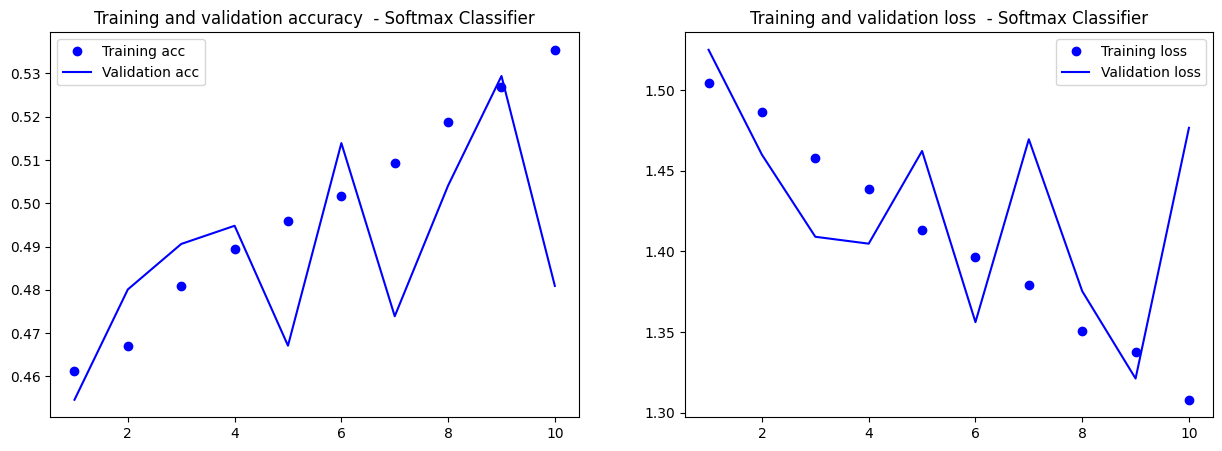

In [19]:
plot_training_history(history, title=' - Softmax Classifier')


Training and Validation Accuracy Graph

The graph showing training and validation accuracy over 10 epochs indicates that the model is learning, with training accuracy generally trending upward despite some fluctuations. However, the validation accuracy, while tracking closely with training accuracy, also exhibits volatility and does not show consistent improvement. This pattern suggests that the model might be struggling to generalize effectively to unseen data, possibly due to overfitting, insufficient complexity in the model, or not enough training epochs to achieve stable performance.

Training and Validation Loss Graph

The loss graph depicts a decreasing trend in training loss, indicating that the model is effectively minimizing the error on the training data across epochs. Conversely, the validation loss, although generally decreasing, shows greater fluctuations. This behavior implies potential issues with how the model performs on validation data, such as sensitivity to specific data characteristics or overfitting, evidenced by its failure to produce consistent loss reductions on data outside of the training set.


Step 5: Embedding Visualization

To visualize embeddings, you can use t-SNE or PCA to reduce the dimensionality of the embeddings to two dimensions and plot them:

1563/1563 [==============================] - 32s 20ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.003s...
[t-SNE] Computed neighbors for 50000 samples in 22.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 1200

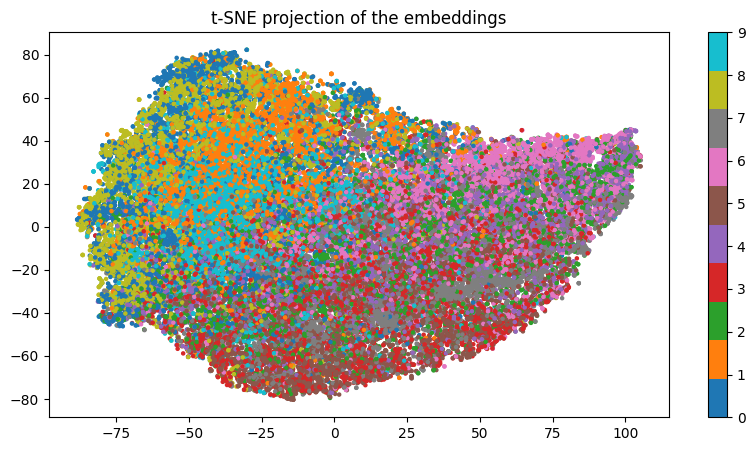

In [20]:
from sklearn.manifold import TSNE

# Assuming `base_model` outputs embeddings
train_embeddings = base_model.predict(train_images)
train_labels_flat = train_labels.flatten()

tsne = TSNE(2, verbose=1)
train_tsne_embeddings = tsne.fit_transform(train_embeddings)

plt.scatter(train_tsne_embeddings[:, 0], train_tsne_embeddings[:, 1], c=train_labels_flat, cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE projection of the embeddings')
plt.show()


Overall conclusion:

The visualization and the metrics suggest that the t-SNE algorithm has successfully reduced the dimensions of your data while preserving the underlying structure, allowing you to visually interpret the relationships and clustering within your dataset. The output values provide confidence that the 2D mapping maintains the integrity of the original data’s relationships, offering valuable insights into the natural groupings and similarities within the data.